In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, wishart
from scipy.special import digamma
import data, random

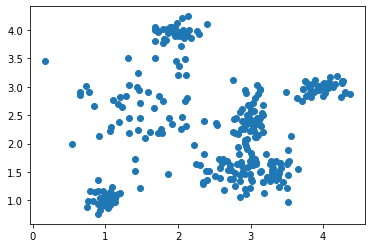

In [2]:
centers_x = [1, 1.5, 2,   3,   3, 4]
centers_y = [1, 2.5, 4, 1.5, 2.3, 3]
covs = [np.array([[1, 0],[0, 1]]), 
        np.array([[25, 0.3],[0.3, 36]]),
        np.array([[2, 0.3],[0.3, 1]]),
        np.array([[10, -0.3],[-0.3, 4]]),
        np.array([[1, 0.3],[0.3, 10]]), 
        np.array([[5, 0.1],[0.1, 2]])]
datanums = [60, 60, 40, 80, 60, 40]

K = 10

data = []

for i in range(len(centers_x)):
    p = multivariate_normal((centers_x[i], centers_y[i]), covs[i]/100)
    data.extend(p.rvs(datanums[i]))
    
#random.shuffle(data)
data.sort(key = lambda x: x[0])
#print(data)

plt.scatter([x for (x,y) in data], [y for (x,y) in data])


In [3]:

def initial_r(data):
    rs = []
    for i,d in enumerate(data):
        r = [0]*K
        p = int(i/len(data)*K)
        r[p] = 1.0
        
        rs.append(r)
        
    return rs

In [4]:
rs = initial_r(data)

In [5]:
def weighted_num(k, rs):
    return sum([r[k] for r in rs])

def weighted_mean(k, rs, data):
    return sum([ r[k]*p for (r, p) in zip(rs, data)])/weighted_num(k, rs)
    
def weighted_cov(k, rs, data):
    xbar = weighted_mean(k, rs, data)
    return sum([ r[k]*(p-xbar).reshape((2, 1)).dot((p-xbar).reshape((2, 1)).T) for (r, p) in zip(rs, data)])/weighted_num(k, rs)

In [6]:
def update_params(org_alpha, org_beta, org_nu, org_m, org_w_inv, k, ns, xs, covs):
    alpha = org_alpha + ns[k]
    beta = org_beta + ns[k]
    nu = org_nu + ns[k]
    m = (org_beta * org_m + ns[k]*xs[k])/beta
    w_inv = org_w_inv + ns[k]*covs[k] + (org_beta*ns[k])/(org_beta + ns[k])*(xs[k] - org_m).reshape((2,1)).dot((xs[k] - org_m).reshape((2,1)).T)
    
    return (alpha, beta, nu, m, w_inv)

In [7]:
def rho(d, k, alphas, betas, nus, ms, w_invs):
    first = digamma(alphas[k]) - digamma(sum(alphas))
    second_2 = digamma((nus[k])/2) + digamma((nus[k] - 1)/2) + np.log(1/np.linalg.det(w_invs[k]))
    third_2 = 2/betas[k] + nus[k]*(d - ms[k]).reshape((2,1)).T.dot(np.linalg.inv(w_invs[k])).dot((d - ms[k]).reshape((2,1)))[0][0]
    
    log_rho = first + second_2/2 - third_2/2
    
    return np.exp(log_rho)

In [8]:
def calc_rs(alphas, betas, nus, ms, w_invs):
    rs = []
    for d in data:
        rhos = [ rho(d, k, alphas, betas, nus, ms, w_invs) for k in range(K)]
        sm = sum(rhos)
        rs.append(rhos/sm)
        
    return rs

In [9]:
def graph(data, ms, betas, w_invs, ns):
    plt.scatter([x for (x,y) in data], [y for (x,y) in data])
    plt.scatter([x for (x,y) in ms], [y for (x,y) in ms], color="red")
    sigmas = [ w_invs[k]/betas[k]/2 for k in range(K)]
    
    normals = [multivariate_normal(mean=ms[k], cov=sigmas[k]) for k in range(K) ]
    
    x, y = np.mgrid[0:5:100j, 0:4:100j]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x 
    pos[:, :, 1] = y 

    for k,n in enumerate(normals):
        if ns[k] > 1:
            plt.contour(x, y, n.pdf(pos), levels=3) 
            
    plt.show()
    

In [10]:
alphas = [1]*K
betas = [1]*K
nus = [1]*K
ms = [np.array([0,0])]*K
w_invs = [np.array([[1, 0],[0, 1]])]*K

In [11]:

def one_step(rs, draw=False):
    ns = [weighted_num(k, rs) for k in range(K)]
    xs = [weighted_mean(k, rs, data) for k in range(K)]
    covs = [weighted_cov(k, rs, data) for k in range(K)]

    print(ns)
    for k in range(K):
        if ns[k] < 0.01:
         #   ms[k] = np.array([0,0])
            continue
            
        params = update_params(1,1,1, np.mean(data), np.array([[1, 0],[0, 1]]), k, ns, xs, covs)
        alphas[k] = params[0]
        betas[k] = params[1]
        nus[k] = params[2]
        ms[k] = params[3]
        w_invs[k] = params[4]

  
    if draw:
        plt.figure()
        graph(data, ms, betas, w_invs, ns)
    return calc_rs(alphas, betas, nus, ms, w_invs)
    
#    print(alphas)
#    print(betas)
#    print(nus)

#    print(w_invs)
#    print(ms) 
#    print(rs)

In [12]:
print("初期の負担率から")
rs = one_step(rs)

初期の負担率から
[34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0]


[28.524714513648064, 43.14962945585803, 30.508304490013956, 37.4124690086207, 25.2343397000601, 33.28910237896383, 36.76806136672406, 36.23251525145189, 29.343541963797286, 39.53732187086199]
[19.448789775076083, 54.575220210903204, 28.21170970618621, 39.978106729879975, 18.57934899634301, 33.5722255954035, 37.96807470432805, 37.542952984532, 28.136615787945342, 41.98695550940265]
[14.286440669310998, 61.01520002512097, 27.022614295726612, 42.62722884178103, 13.21812465699737, 33.25138629017744, 38.542204008819674, 38.456232460930586, 28.309525704605726, 43.27104304652961]
[12.760755162458116, 62.750619167605926, 27.15469672961686, 44.949731494584576, 9.041500001194649, 32.35031812871446, 38.78001905283876, 39.312343357657916, 28.51727023394435, 44.38274667138441]
5回目
[12.062933534565515, 63.19305925904889, 28.246580451378225, 46.30434230417898, 5.992699421013187, 31.06372970887289, 38.8446067566711, 40.27078120374098, 28.596437871085552, 45.42482948944462]


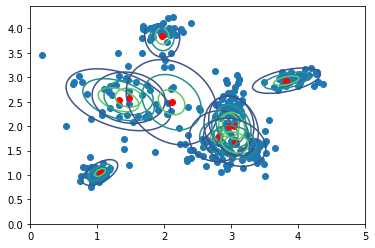

[11.15033875320078, 63.366037720919365, 30.16030951166661, 46.76727515849557, 3.7943989047169198, 29.5350873921796, 38.84412679861754, 41.43095670820877, 28.556192654312536, 46.39527639768235]
[9.945856719551633, 63.460042122580795, 32.33769224471387, 46.894415064110476, 2.1112229011109735, 27.875737925250487, 38.81673118566915, 42.83587286633532, 28.443956029499304, 47.278472941177895]
[8.502085782961062, 63.51238677750371, 34.49374852836774, 46.944129644103164, 0.8561222110709079, 26.1196339109447, 38.73949870953475, 44.48784582668653, 28.277591955584196, 48.06695665324321]
[6.876645544301659, 63.54189640080962, 36.44297926585949, 46.97596164294347, 0.1498391124786706, 24.26189392878146, 38.5636045527754, 46.37429242303586, 28.05484903476886, 48.758038094245485]
10回目
[5.1601747008802095, 63.55277439507122, 38.10393345700964, 46.994363404254685, 0.00016610445318761323, 22.301197905903575, 38.25265093085041, 48.501412972192604, 27.787583192869196, 49.34574293651529]


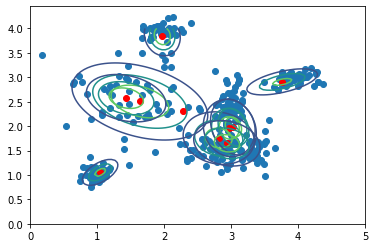

[3.47426431915343, 63.55817204473858, 39.5738329983045, 47.01611690457955, 0.00016609345610098928, 20.264720899841837, 37.81307185637387, 50.92864994210972, 27.525781805118896, 49.84522313632347]
[1.9442064800240382, 63.56280421713156, 40.82256520694536, 47.04538255459863, 0.00016607220854785953, 18.148375263367587, 37.222453975694755, 53.68739202259033, 27.29915035820007, 50.267503849239105]
[0.7521762970347792, 63.56516243272579, 41.72238283872535, 47.07514660356511, 0.00016564834228618823, 15.935487179005142, 36.43984095780065, 56.776123857596176, 27.12011311193263, 50.613401073272044]
[0.11047693867753852, 63.56122233059942, 42.16340516482619, 47.09060606703709, 0.00016472719886376062, 13.617805877874154, 35.42287690329274, 60.16272055936424, 26.993370155796622, 50.87735127533298]
15回目
[1.3592721384799655e-05, 63.54773274019485, 42.251504937986304, 47.08169048005764, 0.00016374717346617722, 11.214878830689155, 34.14479614031096, 63.789244656571945, 26.923900799671003, 51.0460740746

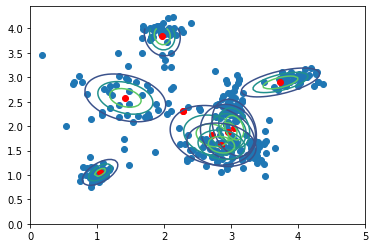

[1.356271479265314e-05, 63.536010133697545, 42.26745972702408, 47.071111435528536, 0.0001633879514196857, 8.795112829998196, 32.63011872446732, 67.62593836533256, 26.943001041801303, 51.131070791484134]
[1.3548927437786523e-05, 63.528041735041676, 42.29743142743672, 47.063430656820806, 0.00016322322143110543, 6.444128199019712, 30.892374538440603, 71.58400721063228, 27.04919440610151, 51.1412150543578]
[1.3537930055823432e-05, 63.52340381073631, 42.38108146958039, 47.05791469814878, 0.00016309204906697747, 4.273680722491322, 28.942359699897153, 75.52574915489457, 27.21562870755164, 51.080005106720805]
[1.3526557837058314e-05, 63.52310672698411, 42.550793201606766, 47.057677272826915, 0.00016295553785762763, 2.4164348290415756, 26.79722821609075, 79.29739330104461, 27.406278940386596, 50.95091102992298]
20回目
[1.3507173692823712e-05, 63.52783471922852, 42.795441528963195, 47.06823767567484, 0.0001627194536179475, 1.0145035697552616, 24.481771364690513, 82.76179905586211, 27.5942306991200

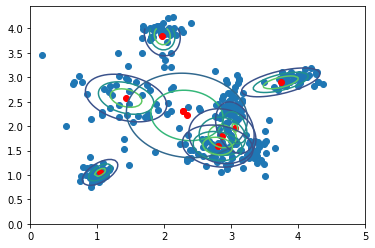

[1.3466826301178422e-05, 63.53374109850863, 43.01140943901147, 47.087088416416805, 0.00016222642823710538, 0.20711262437050976, 22.034393637724516, 85.84012098822927, 27.791106054925656, 50.494852047558524]
[1.3404580364773982e-05, 63.53129792823917, 43.066784501150494, 47.0931437056707, 0.0001614715122655597, 0.001185504761350736, 19.512790077861258, 88.5500063234262, 28.072862287770015, 50.171754795028114]
[1.3370666185798023e-05, 63.524909885787615, 43.046445356086615, 47.08913408140639, 0.00016106309904424196, 0.0011825081365329452, 16.973186539880913, 90.98641896669791, 28.556093764744563, 49.82245446349432]
[1.3360588756330034e-05, 63.51963743763527, 43.030075988672344, 47.08597741679855, 0.00016094266039409056, 0.0011816289949681447, 14.420148966606348, 93.1623391721484, 29.303564406348187, 49.476900679546794]
25回目
[1.3353507707921888e-05, 63.51472020173081, 43.026017109851345, 47.08240235877087, 0.00016085864485913346, 0.0011810157040828804, 11.849199606486266, 95.0408264538453

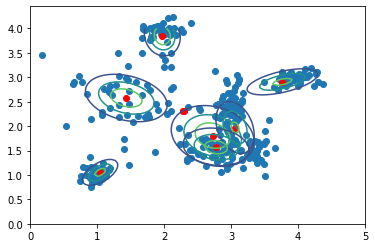

[1.3347076463157684e-05, 63.510378072367274, 43.049521390574235, 47.0776459623555, 0.00016078272272246878, 0.0011804543405001034, 9.287250622618387, 96.57862964711954, 31.65048380450489, 48.84473591632047]
[1.3340575679231897e-05, 63.50737935075646, 43.12792552098582, 47.07152147554162, 0.00016070620196707256, 0.0011798752630992637, 6.807961373552587, 97.72357244090563, 33.18882041305808, 48.5714655031591]
[1.333446322932511e-05, 63.50714517015276, 43.30034868231504, 47.06534600975523, 0.00016063440656511544, 0.001179311657127817, 4.528714736763816, 98.42312573588401, 34.844959692563314, 48.32900669203884]
[1.3327289956946374e-05, 63.5117464902062, 43.599285544536876, 47.06353111630577, 0.0001605488069368787, 0.0011786156518889305, 2.5867215152238408, 98.64241518957326, 36.48086850545718, 48.11407914694797]
30回目
[1.3310915994814175e-05, 63.52280009689078, 44.002140568315966, 47.07283485130019, 0.00016034857630826762, 0.0011770214536735615, 1.1173944425023434, 98.38448961383651, 37.9801

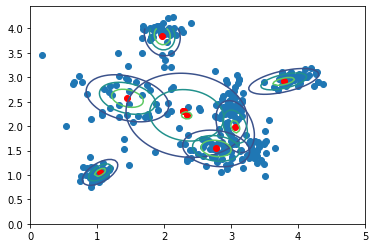

[1.3270518994234338e-05, 63.537237316962035, 44.379480623509814, 47.09202214813884, 0.0001598531358154622, 0.0011731977597155333, 0.24955671233844745, 97.7089942562344, 39.301878998335134, 47.72948362306685]
[1.3201076713247592e-05, 63.54436236727247, 44.56989439248194, 47.099812342485, 0.00015900879667139794, 0.0011668624024580778, 0.0029464605701331253, 96.75005647935777, 40.50227765722963, 47.52931122832699]
[1.315199725872113e-05, 63.54610526217384, 44.64968351314932, 47.09597603760966, 0.0001584155713136633, 0.0011624594410492765, 0.002935355549018494, 95.69007589938106, 41.68736833425731, 47.3265215708702]
[1.3128924372990136e-05, 63.5488725128998, 44.71880797542141, 47.09408562455695, 0.000158136377161677, 0.0011603656623730004, 0.0029300992552933024, 94.60704690656013, 42.89305689208777, 47.133868358254716]
35回目
[1.3109145191045082e-05, 63.55172425130898, 44.78056325378483, 47.093081124418205, 0.00015789700951816446, 0.001158568107367394, 0.002925589589550517, 93.51053994407168

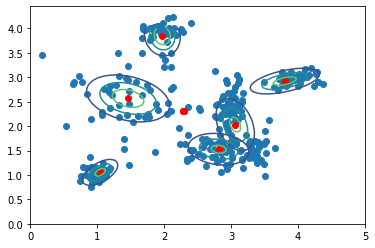

[1.3091833827178423e-05, 63.554483483868275, 44.8366781873112, 47.09249496324581, 0.00015768752345419066, 0.0011569940781651308, 0.0029216425336163476, 92.41022224593698, 45.322381566286936, 46.779490137381664]
[1.3076645478820641e-05, 63.557117470328286, 44.88813861786783, 47.09211665283769, 0.00015750375329144916, 0.0011556129625426702, 0.0029181804889514195, 91.31474336398, 46.52611336210502, 46.61752615903082]
[1.3063365569492118e-05, 63.559621295280856, 44.93553956751313, 47.091854214138266, 0.0001573430975034664, 0.0011544054798120042, 0.002915154590392893, 90.2313142353741, 47.71221090972423, 46.46521981143597]
[1.305182103702846e-05, 63.56199642824948, 44.97927111262354, 47.091668697445506, 0.00015720345413311592, 0.0011533559444001163, 0.002912525147901334, 89.16555773686305, 48.87525007016093, 46.32201981828998]
40回目
[1.304185384313229e-05, 63.564247093907596, 45.01962014208772, 47.09154408153718, 0.00015708290292252205, 0.0011524499651760006, 0.0029102558166444557, 88.121500

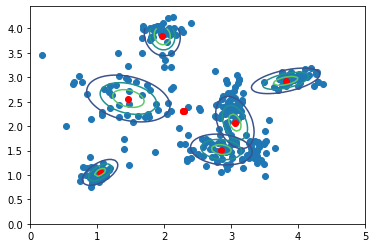

[1.303331346162479e-05, 63.56637958771402, 45.05682649194537, 47.091473764462286, 0.0001569796153693504, 0.0011516738049334686, 0.0029083119630010923, 87.10165526833866, 51.1191787117428, 46.06025617710005]
[1.3026055857723029e-05, 63.568401914572874, 45.09111287806741, 47.09145465625043, 0.0001568918427269506, 0.0011510143072015208, 0.0029066604650296564, 86.10715327390645, 52.19745131734362, 45.94019836718839]
[1.301994463039216e-05, 63.57032340495135, 45.12269929678821, 47.09148471000475, 0.00015681792990035554, 0.0011504590099615025, 0.0029052699860385354, 85.13791862768424, 53.24704217184992, 45.82630622185097]
[1.3014852614806468e-05, 63.57215432471847, 45.15180826065916, 47.09156198854679, 0.00015675633475612918, 0.0011499962961673213, 0.002904111342366388, 84.19284891281659, 54.269623066852425, 45.717779567580614]
45回目
[1.3010663258147203e-05, 63.57390552013226, 45.178664891786134, 47.09168440019111, 0.00015670564460464628, 0.0011496155207147707, 0.0029031578133629997, 83.26999

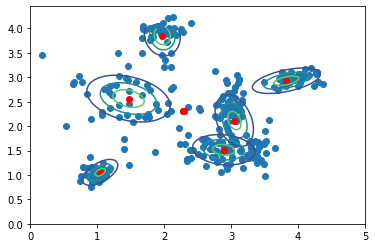

[1.3007271535045423e-05, 63.57558812123214, 45.203494466048134, 47.09184970912799, 0.00015666458707315256, 0.0011493070937343614, 0.002902385343041831, 82.36672796187781, 56.24445519378775, 45.513663183630825]
[1.3004584384641517e-05, 63.5772133115352, 45.22651904983904, 47.092055641038954, 0.00015663203518277854, 0.0011490625192585255, 0.002901772631078821, 81.47987831972291, 57.20357687948854, 45.41653632660535]
[1.300252075190671e-05, 63.578792162409265, 45.24795420776863, 47.092300003346935, 0.0001566070076489984, 0.0011488743972213813, 0.0029013011331151086, 80.6058580974332, 58.14916897629575, 45.32170676768751]
[1.3001011357938327e-05, 63.5803355246365, 45.26800629561795, 47.09258078529089, 0.0001565886659244492, 0.0011487364004013922, 0.002900954999393046, 79.74075265681196, 59.08564862728574, 45.22845682927986]
50回目
[1.2999998338294168e-05, 63.581853965858194, 45.28687053638761, 47.0928962242491, 0.00015657630966932085, 0.0011486432390846145, 0.0029007209836160856, 78.88039362

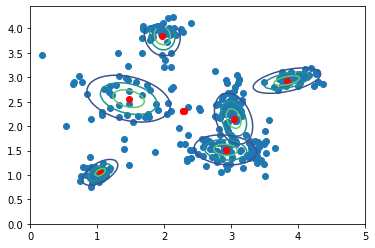

In [13]:
for j in range(20):
    for i in range(5):
        if i==4:
            print("{}回目".format(j*5+5))
        rs = one_step(rs, i==4)